In [ ]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 
import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd
import sys

# Random seed for reproducibility
import random

import torch
from botorch.utils.transforms import unnormalize, normalize

from ipywidgets import interact, FloatSlider

#LHS sampling
#from pyDOE import lhs

#from BOClass import Models, Plotting, PoolObjectives
from boclass_query import Models, Plotting, PoolObjectives

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
all_data = pd.read_csv('all_data.csv') # all_df = pd.concat([data01, data2A, data2B, data2C, data3A, data3B, data3C], axis=0, ignore_index=True)
data01 = all_data[:15]
data2A = all_data[15:30]
data2B = all_data[30:45]
data2C = all_data[45:60]
data3A = all_data[60:75]
data3B = all_data[75:90]
data3C = all_data[90:105]
# Model Sets
set_dataA = pd.concat([data01, data2A, data3A], axis=0, ignore_index=True)
set_dataB = pd.concat([data01, data2B, data3B], axis=0,ignore_index=True)
set_dataC = pd.concat([data01, data2C, data3C], axis=0,ignore_index=True)


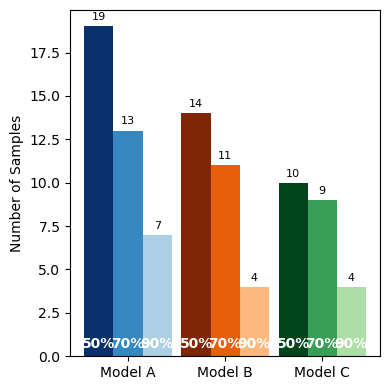

In [3]:
# Check Data
thresholds = [0.5, 0.7, 0.9]

# Calculate counts for each threshold for each model
counts_A = [ (set_dataA['yield product'] > thresh).sum().item() for thresh in thresholds ]
counts_B = [ (set_dataB['yield product'] > thresh).sum().item() for thresh in thresholds ]
counts_C = [ (set_dataC['yield product'] > thresh).sum().item() for thresh in thresholds ]

model_counts = [counts_A, counts_B, counts_C]
model_names = ['ModelA', 'ModelB', 'ModelC']  # Used for cm.*
num_bars_per_model = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(len(model_names))

# Colormap mapping
cmap_dict = {'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot each model group
for i, (model, counts) in enumerate(zip(model_names, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'{thresholds[j]*100:.0f}%', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.tight_layout()
plt.show()


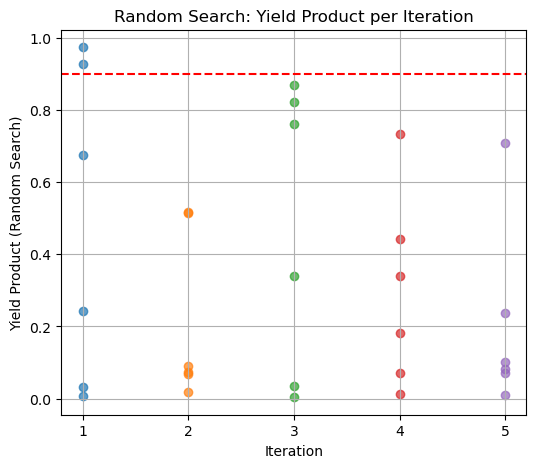

In [4]:
random_seed = 1
iterations = 5
# Perform a random search on set_dataA for 5 random samples

iteration = np.arange(1, iterations+1)

batch_size = 6
num_samples = batch_size * iterations
random_samples = all_data.sample(n=num_samples, random_state=random_seed)
random_sampling = [random_samples.iloc[i*batch_size:(i+1)*batch_size]['yield product'] for i in range(iterations)]


plt.figure(figsize=(6, 5))
for i, samples in enumerate(random_sampling):
    plt.scatter([iteration[i]] * len(samples), samples.values, alpha=0.7)
plt.xlabel('Iteration')
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
plt.ylabel('Yield Product (Random Search)')
plt.title('Random Search: Yield Product per Iteration')
plt.grid(True)
plt.xticks(range(1, iterations + 1))
plt.show()


In [5]:
# Iteration 0: Set up gp with initial data
original_bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)


x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=torch.float32)
nx_all = normalize(x_all,original_bounds)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=torch.float32)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=torch.float32)

random.seed(5)
random_indices = random.sample(range(x_all.shape[0]), batch_size)
x_train = x_all[random_indices]
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

y_train = y_all[random_indices]
y_train_var = yvar_all[random_indices]



# Remove x_train rows from x_inputs
# Convert x_train to numpy for comparison
x_train_np = x_train.cpu().numpy()
# Find all rows in x_inputs that are not in x_train
mask = ~x_inputs.apply(lambda row: ((x_train_np == row.values).all(axis=1)).any(), axis=1)
x_input_new = x_inputs[mask]
y_output_new = y_outputs[mask]
yvar_output_new = yvar_outputs[mask]
query = PoolObjectives(x_input_new, y_output_new ,yvar_output_new)
# Step 1: Initialize your model
gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query)

# Step 2: Initialize Plotting class
# variable_combinations = [('time', 'sulf', 'anly'), ('time', 'anly', 'sulf'), ('sulf', 'anly', 'time')]
# plotting = Plotting(gp_model, variable_combinations=variable_combinations)

# combination = variable_combinations[0]
# minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelA',combination, minmax)



In [6]:
def BO_loop_ModelA(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all)
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelA_candidates(feature='temp').drop(columns=['cluster'])
        
        #print(new_candidates.shape)
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)
        print(used_id)

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


[58, 86, 86, 8, 92, 61]
[8, 93, 66, 19, 51, 93]
[8, 41, 8, 3, 3, 8]
[8, 9, 33, 2, 9, 8]
[8, 83, 93, 3, 8, 8]


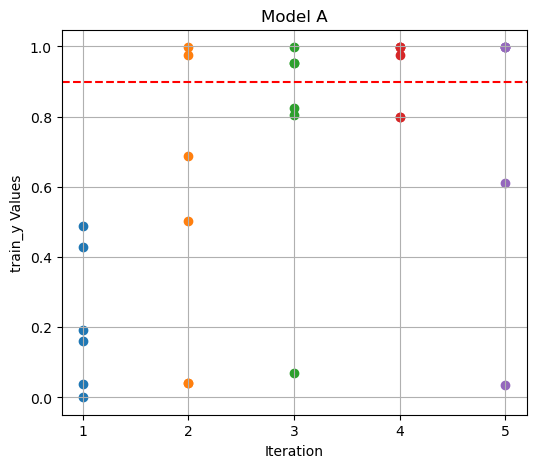

Iteration 1: tensor([198., 148.,  85., 100.])
Iteration 2: tensor([353., 145.,  94.,  66.])
Iteration 3: tensor([353., 145.,  94.,  66.])
Iteration 4: tensor([353., 145.,  94.,  66.])
Iteration 5: tensor([391., 145.,  97.,  35.])


In [7]:

gp_modeA, train_nA, train_yA, train_yvaA = BO_loop_ModelA(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xA = unnormalize(train_nA, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modeA, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelA',combination, minmax)

# Split train_y intoA iterations, each containingA points

points_per_iteration = batch_size
split_data = [train_yA[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xA[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Model A')
plt.xticks(range(1, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

In [8]:
def BO_loop_ModelB(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all)
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelB_candidates(feature='temp')#.drop(columns=['cluster'])
        
        #print(new_candidates.shape)
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


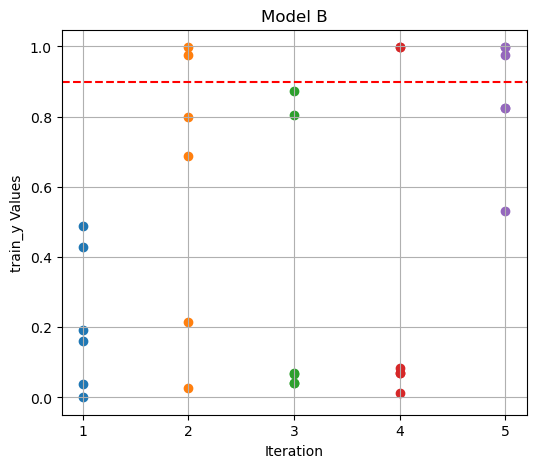

Iteration 1: tensor([198., 148.,  85., 100.])
Iteration 2: tensor([391., 145.,  97.,  35.])
Iteration 3: tensor([295., 138.,  96.,  64.])
Iteration 4: tensor([391., 145.,  97.,  35.])
Iteration 5: tensor([391., 145.,  97.,  35.])


In [9]:
# Reset Pool
x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

gp_modelB, train_nxB, train_yB, train_yvarB = BO_loop_ModelB(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xB = unnormalize(train_nxB, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelB, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelB',combination, minmax)


points_per_iteration = batch_size
split_data = [train_yB[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xB[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Model B')
plt.xticks(range(1, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

In [10]:
def BO_loop_ModelC(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all)
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelC_candidates(feature='temp')#.drop(columns=['cluster'])
        
        #print(new_candidates.shape)
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


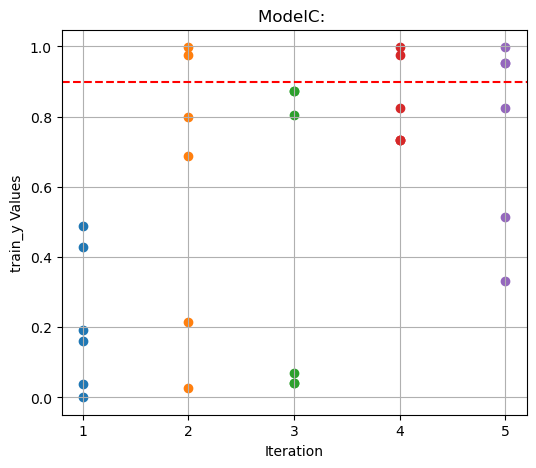

Iteration 1: tensor([198., 148.,  85., 100.])
Iteration 2: tensor([391., 145.,  97.,  35.])
Iteration 3: tensor([295., 138.,  96.,  64.])
Iteration 4: tensor([391., 145.,  97.,  35.])
Iteration 5: tensor([391., 145.,  97.,  35.])


In [11]:
# Reset 
x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

gp_modelC, train_nxC, train_yC, train_yvarC = BO_loop_ModelC(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xC = unnormalize(train_nxC, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelC, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelC',combination, minmax)


points_per_iteration = batch_size
split_data = [train_yC[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xC[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('ModelC: ')
plt.xticks(range(1, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()

argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")



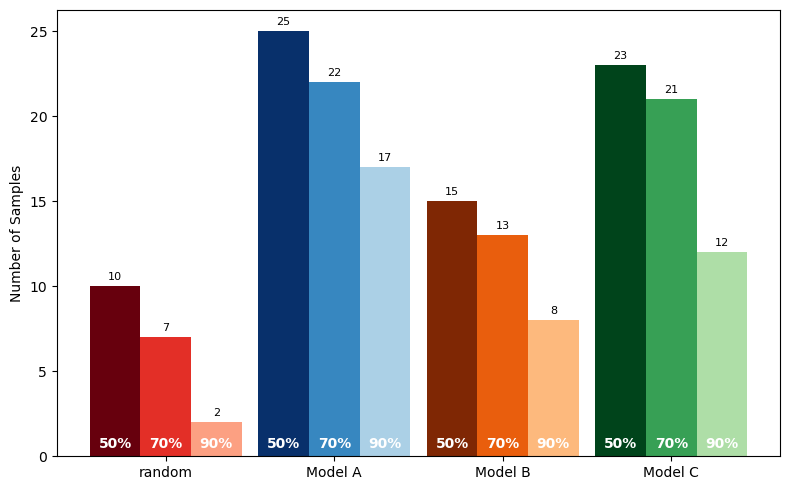

In [12]:
# Check Data
thresholds = [0.5, 0.7, 0.9]

flattened_random_sampling = torch.cat([torch.tensor(samples.values, dtype=torch.float32) for samples in random_sampling]).reshape(-1, 1)


idsA = [(train_yA > thresh).sum().item() for thresh in thresholds]
idsB = [(train_yB > thresh).sum().item() for thresh in thresholds]
idsC = [(train_yC > thresh).sum().item() for thresh in thresholds]
ids_random = [(flattened_random_sampling > thresh).sum().item() for thresh in thresholds]


model_counts =[ids_random,idsA,idsB,idsC] 
model_names = ['random','ModelA', 'ModelB', 'ModelC']  # Used for cm.*
num_bars_per_model = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(len(model_names))

# Colormap mapping
cmap_dict = {'random':cm.Reds, 'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot each model group
for i, (model, counts) in enumerate(zip(model_names, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['random','Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'{thresholds[j]*100:.0f}%', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.tight_layout()
plt.show()

